URL : https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

## Introduction
In this competition, we are challenged to build a model that predicts the total ride duration of taxi trips in New York City.<br>
There are quite a few EDA kernels and some of them are excellent.<br>
Here I try to focus more on the feature extraction.<br>
In this Kernel you could find a few general kaggle related trips and a some modeling improvement ideas as well.

#### My main goal is to craft the best possible feature set for XGB with given Kernel limitations.
<br>
My current best submission is still based on this script.<br>
My best single model with these features reached LB 0.371.<br>
Linear combination of serveral models gave LB 0.368<br>
Stacking added marginal improvement to 0.367<br><br>
Please feel free to fork and use the features and search for better parameters.<br><br>
With this simple notebook we<br>

* Explore the dataset
* Extract 59 useful features
* Create simple 80-20 train - validation set
* Train XGBregressor
* Analyze Feature Importance
* Score test set and submit
* Check XGB parameter search result for further improvements

#### References

* I used a few feature extraction ideas from Nir Melbin's Kernel
* Thanks for oscaleo for this external dataset

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')

## First week progress

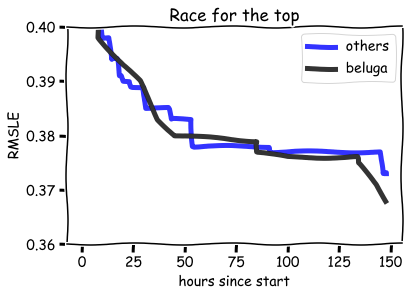

In [2]:
beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]}) 
with plt.xkcd():
    # This figure will be in XKCD-style
    fig, ax = plt.subplots()
    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')
    plt.show()

## Data understanding

In [3]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')
sample_submission = pd.read_csv('./input/sample_submission.csv')

Let's check the data files! According the data description we should find the following columns :<br>

* **id** : a unique identifier for each trip
* **vendor-id** : a code indicating the provider associated with the trip record
* **pickup_datetime** : date and time when the meter was engaged
* **dropoff_datetime** : data and time when the meter was disengaged
* **passenger_count** : the number of passengers in the vehicle (driver entered value)
* **pickup_longitube** : the longitude where the meter was engaged
* **pickup_latitude** : the latitude where the meter was engaged
* **dropoff_longitube** : the longitude where the meter was engaged
* **dropoff_latitude** : the latitude where the meter was engaged
* **store_and_fwd_flag** : This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y = store and forward; N = not a store and forward trop)
* **trip_duration** : duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the train set.

In [4]:
print('We have {} training rows and test rows.'.format(train.shape[0], test.shape[0]))
print('We have {} training columns and test columns.'.format(train.shape[1], test.shape[1]))
train.head(2)

We have 1458644 training rows and test rows.
We have 11 training columns and test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [5]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] and test.count().min() == test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'. format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}.


In [6]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [7]:
train['trip_duration'].max() // 3600

979

We can see that max trip_duration is ~1000 hours.<br>
Fortunately the evaluation metric is RMSLE and not RMSE.<br>
Outliers will cause less trouble.<br>
We could logtransform our target and use RMSE during training.

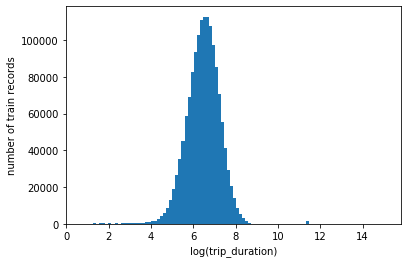

In [8]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

### Validation Strategy
First let's check the train test split.<br>
It helps to decide our validation strategy and gives ideas about feature engineering.

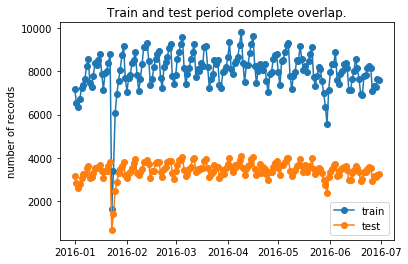

In [9]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

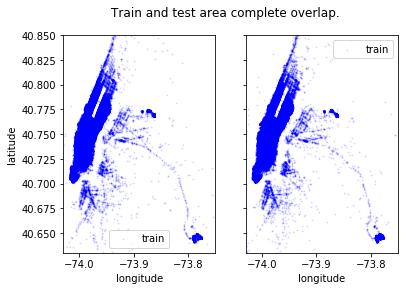

In [10]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 2, sharex = True, sharey = True)
ax[0].scatter(
    train['pickup_longitude'].values[:N],
    train['pickup_latitude'].values[:N],
    color = 'blue',
    s = 1,
    label = 'train',
    alpha = 0.1
)
ax[1].scatter(
    test['pickup_longitude'].values[:N],
    test['pickup_latitude'].values[:N],
    color = 'blue',
    s = 1,
    label = 'train',
    alpha = 0.1
)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In this case the train and test split seems to be random.<br>
This allows us to unsupervised learning and feature extraction to be applied on the full data set.

## Feature Extraction

### PCA
We use PCA to transform longitude and latitude coordinates.<br>
In this case it is not about dimension reduction since we transform 2D-> 2D.<br>
The rotation could help for decision tree splits.

In [11]:
coords = np.vstack(
    (
        train[['pickup_latitude', 'pickup_longitude']].values,
        train[['dropoff_latitude', 'dropoff_longitude']].values,
        test[['pickup_latitude', 'pickup_longitude']].values,
        test[['dropoff_latitude', 'dropoff_longitude']].values
    )
)

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

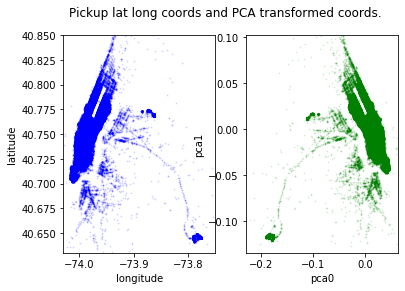

In [12]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(
    train['pickup_longitude'].values[:N], 
    train['pickup_latitude'].values[:N],
    color='blue', 
    s=1, 
    alpha=0.1
)
ax[1].scatter(
    train['pickup_pca0'].values[:N], 
    train['pickup_pca1'].values[:N],
    color='green', 
    s=1, 
    alpha=0.1
)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

### Distance
Let's calculate the distance(km) between pickup and dropoff points.<br>
Currently Haversine is used, geopy has another heuristics(vincenty() or great_circle()) if you prefer.<br>
The cabs are not flying and we are in New York so we could check the Manhattan(L1) distance too.<br>

pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.<br>
We extract the middle of the path a feature as well.

In [13]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

### Datetime features

In [14]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

### Speed

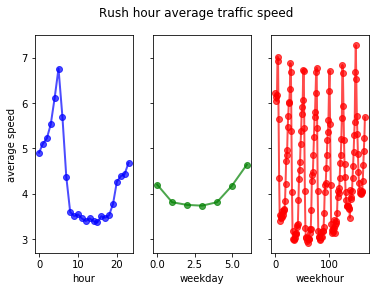

In [15]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

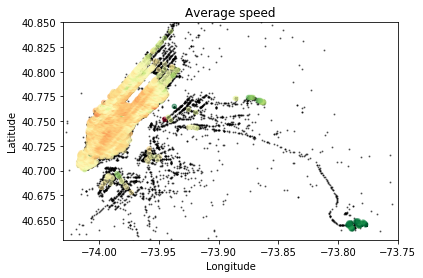

In [16]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

### Clustering

In [17]:
sample_ind = np.random.permutation(len(coords))[:5000]
kmeans = MiniBatchKMeans(
    n_clusters=100,
    batch_size=10000,
).fit(coords[sample_ind])

In [18]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()
print('Time till clustering: %i seconds' % (t1 - t0).seconds)

Time till clustering: 178 seconds


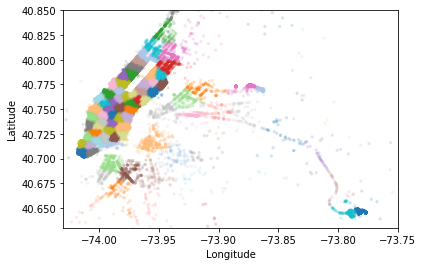

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(
    train.pickup_longitude.values[:N], 
    train.pickup_latitude.values[:N], 
    s=10, 
    lw=0,
    c=train.pickup_cluster[:N].values, 
    cmap='tab20', 
    alpha=0.2
)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Temporal and geospatial aggregation
Add a few average traffic speed features.<br>
Note that if the train/test split would be time based then we could not use as much temporal features.<br>
In this competition we do not need to predict the future.

In [23]:
# for gby_col in ['pickup_hour', 'pickup_date', 'pickup_dt_bin', 'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
#     gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_trip_duration']]
#     gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
#     train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
#     test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

# for gby_cols in [['center_lat_bin', 'center_long_bin'],
#                  ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
#                  ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
#                  ['pickup_cluster', 'dropoff_cluster']]:
#     coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
#     coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
#     coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
#     coord_stats = coord_stats[coord_stats['id'] > 100]
#     coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
#     train = pd.merge(train, coord_stats, how='left', on=gby_cols)
#     test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [24]:
# group_freq = '60min'
# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
# test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

# # Count trips over 60min
# df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
# df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
# train = train.merge(df_counts, on='id', how='left')
# test = test.merge(df_counts, on='id', how='left')

# # Count how many trips are going to each cluster over time
# dropoff_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.Grouper(group_freq), 'dropoff_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('dropoff_cluster').rolling('240min').mean() \
#     .drop('dropoff_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

# train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
# test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

# Count how many trips are going from each cluster over time
# df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
# pickup_counts = df_all \
#     .set_index('pickup_datetime') \
#     .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
#     .agg({'id': 'count'}) \
#     .reset_index().set_index('pickup_datetime') \
#     .groupby('pickup_cluster').rolling('240min').mean() \
#     .drop('pickup_cluster', axis=1) \
#     .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
#     .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

# train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
# test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)

### OSRM Features
We had only rough distance estimates in the previous versions.<br>
Now we use better fastest route distance estimates between pickup and dropoff.

In [28]:
fr1 = pd.read_csv(
    './input/fastest_routes_train_part_1.csv',
    usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps']
)
fr2 = pd.read_csv(
    './input/fastest_routes_train_part_2.csv',
    usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
)
test_street_info = pd.read_csv(
    './input/fastest_routes_test.csv',
   usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps']
)
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [29]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values + 1)

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 58 features.
Feature extraction time: 5389 seconds


### Feature check before modeling
It might save you some headache to check your train and test feature distributions before modeling.<br>
Usually, in kaggle competitions train and test sets are iid.<br>
If there is huge difference between train and test set than probably you have a bug in your feature extraction pipeline.

In [30]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
43,avg_speed_h_center_lat_bin_center_long_bin,0.002543
21,pickup_dt,0.002648
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872


In [35]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
45,avg_speed_h_pickup_hour_center_lat_bin_center_...,0.081,0.081,0.000
39,log_trip_duration_gby_pickup_cluster,0.000,0.000,0.000
34,avg_speed_h_gby_pickup_week_hour,0.000,0.000,0.000
52,cnt_pickup_cluster_dropoff_cluster,0.081,0.082,0.001
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.081,0.082,0.001


Even the top mean difference is less than 1% of the standard deviation.<br>
We have a few missing values but the missing rates the same.<br>
Fortunately xgboost can candle missing values.